<div class="alert alert-block alert-info">
<span style="color: rgb(0,53,91);">
<center><img src="https://www.redage.org/sites/default/files/styles/large/public/img-logo-institucion/logo_iteso.jpg?itok=IzloBJS1" style="width:500px;height:142px;" title="Logo ITESO"></center>

<font face = "Times New Roman" size = "6"><b><center>Programacion para Mineria de Datos</center></b></font>
<font face = "Times New Roman" size = "5"><b><center>Preprocesamiento PCA</center></b></font>

<b><font back = "Times New Roman" size = "4"><center>Unidad 5: </center></font>
<div align="right"><font face = "Times New Roman" size = "2">nombres: Angel Aceves Manzo</font></div>
<div align="right"><font face = "Times New Roman" size = "2"> Sebastian Garcia-Moreno Zinchenko</font></div>
<div align="right"><font face = "Times New Roman" size = "2"> Jesus Vargas Pacheco</font></div>
</span></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

df = pd.read_csv("iris_dataset.csv")

df.columns

Index(['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'color',
       'nivel', 'Class'],
      dtype='object')

In [2]:
y = df['Class']
X = df.drop(columns=['Class'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, shuffle=True
)

print("Shapes -> X_train:", X_train.shape, " | X_test:", X_test.shape)

Shapes -> X_train: (105, 6)  | X_test: (35, 6)


In [3]:
cols_num = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
cols_cat = ['color', 'nivel']


X_train_num = X_train[cols_num]
X_train_cat = X_train[cols_cat]
X_test_num = X_test[cols_num]
X_test_cat = X_test[cols_cat]

In [4]:
X_train_cat

,color,nivel
83,amarillo,bajo
60,amarillo,alto
106,azul,alto
89,rojo,bajo
78,rojo,bajo
...,...,...
9,rojo,alto
103,rojo,bajo
67,amarillo,alto
117,rojo,alto


In [5]:
########## codificado de columnas categoricas
cols_onehot  = ['color']
cols_ordinal = ['nivel']

# Categorías ordenadas para las ordinales (mismo orden que en cols_ordinal)
categorias_ordinales = [['bajo', 'alto']]


preprocessor_cat = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore"), cols_onehot),
        ("ordinal", OrdinalEncoder(categories=categorias_ordinales, handle_unknown="use_encoded_value", unknown_value=-1), cols_ordinal),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

preprocessor_cat.fit(X_train_cat)

X_train_cat_proc = preprocessor_cat.transform(X_train_cat)
X_test_cat_proc = preprocessor_cat.transform(X_test_cat)

# -----------------------------------------
# Renombrar One-Hot a formato col___categoria
# -----------------------------------------
onehot = preprocessor_cat.named_transformers_.get("onehot")

rename_map = {}
if onehot is not None and len(cols_onehot) > 0:
    for col, cats in zip(cols_onehot, onehot.categories_):
        for cat in cats:
            old = f"{col}_{cat}"      # nombre que entrega sklearn con verbose_feature_names_out=False
            new = f"{col}___{cat}"    # triple guion bajo deseado
            rename_map[old] = new

# Obtener nombres del ColumnTransformer y aplicar renombres solo a OHE
cols_out_cat = preprocessor_cat.get_feature_names_out()
cols_out_cat = [rename_map.get(c, c) for c in cols_out_cat]

# Reconstruir DataFrames con índices originales
df_train_cat_encode = pd.DataFrame(X_train_cat_proc, columns=cols_out_cat, index=X_train_cat.index)
df_test_cat_encode  = pd.DataFrame(X_test_cat_proc,  columns=cols_out_cat, index=X_test_cat.index)
 

In [6]:
###########################
########################### DIAGNÓSTICO DE COLUMNAS
###########################


# 1) Detecta numéricas
print("Columnas numéricas:", cols_num)

# 2) Funciones auxiliares
def iqr_outlier_stats(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0, 0.0, np.nan, np.nan, np.nan, np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_out = int(((s < lim_inf) | (s > lim_sup)).sum())
    prop_out = n_out / len(s)
    return n_out, prop_out, q1, q3, lim_inf, lim_sup

def bounded_guess(s: pd.Series):
    """Detecta si parece estar acotada en [0,1] o [0,100]."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return None
    mn, mx = float(s.min()), float(s.max())
    if 0.0 <= mn and mx <= 1.0:
        return "[0,1]"
    if 0.0 <= mn and mx <= 100.0:
        return "[0,100]"
    return None

if len(cols_num) == 0:
    print("No hay columnas numéricas en X_train. No se generan imágenes.")
else:
    # --------- Figura 1: HISTOGRAMAS (todos en subplots) ----------
    n = len(cols_num)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols_num):
        s = pd.to_numeric(X_train[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Oculta subplots sobrantes
    for j in range(len(cols_num), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("histogramas_numericas.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

    # --------- Figura 2: BOXPLOTS (todas en un eje) ----------
    series_pairs = []
    for c in cols_num:
        v = pd.to_numeric(X_train[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas")
        plt.tight_layout()
        fig2.savefig("boxplots_numericas.png", dpi=150, bbox_inches="tight")
        plt.close(fig2)


# ================================
# Diagnóstico numérico + heurística
# ================================
diagnostico = []
for c in cols_num:
    s = pd.to_numeric(X_train[c], errors="coerce")
    miss_pct = s.isna().mean() * 100
    s_no_na = s.dropna()
    skew = s_no_na.skew() if s_no_na.size > 1 else np.nan
    kurt = s_no_na.kurt() if s_no_na.size > 1 else np.nan
    n_out, prop_out, q1, q3, li, ls = iqr_outlier_stats(s)
    bounds = bounded_guess(s)

    # Heurística de imputación
    if (prop_out >= 0.05) or (pd.notna(skew) and abs(skew) >= 1.0):
        imputador = "median"
    else:
        imputador = "mean"

    # Heurística de escalado
    if prop_out >= 0.05:
        escalador = "RobustScaler"
    elif pd.notna(skew) and abs(skew) <= 0.5:
        escalador = "StandardScaler"
    else:
        escalador = "MinMaxScaler"  # por defecto en casos no normales o acotados

    diagnostico.append({
        "columna": c,
        "missing_%": round(miss_pct, 2),
        "skew": round(skew, 3) if pd.notna(skew) else np.nan,
        "kurtosis": round(kurt, 3) if pd.notna(kurt) else np.nan,
        "outliers_n": n_out,
        "outliers_%": round(prop_out*100, 2),
        "q1": q1, "q3": q3, "IQR": (q3 - q1),
        "lim_inf": li, "lim_sup": ls,
        "bounded": bounds,
        "recom_imputer": imputador,
        "recom_scaler": escalador,
    })

diag_df = pd.DataFrame(diagnostico).sort_values(["outliers_%","missing_%"], ascending=False)
print("\n=== Diagnóstico numérico (heurística) ===\n")

print(diag_df)

# Sugerencias de bloques numéricos (incluye median+Robust)
suggest_mean_rob = diag_df.query("recom_imputer=='mean' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_rob  = diag_df.query("recom_imputer=='median' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_min  = diag_df.query("recom_imputer=='median' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_med_std  = diag_df.query("recom_imputer=='median' and recom_scaler=='StandardScaler'")["columna"].tolist()
suggest_mean_min = diag_df.query("recom_imputer=='mean' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_mean_std = diag_df.query("recom_imputer=='mean' and recom_scaler=='StandardScaler'")["columna"].tolist()

print("\nSugerencias de bloques numéricos (auto):")
print("median+Robust   :", suggest_med_rob)
print("median+MinMax   :", suggest_med_min)
print("median+Standard :", suggest_med_std)
print("mean+Robust     :", suggest_mean_rob)
print("mean+MinMax     :", suggest_mean_min)
print("mean+Standard   :", suggest_mean_std)

Columnas numéricas: ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']

=== Diagnóstico numérico (heurística) ===

       columna  missing_%   skew  kurtosis  outliers_n  outliers_%   q1   q3  \
1   SepalWidth        0.0  0.441     0.427           1        0.95  2.8  3.3   
0  SepalLength        0.0  0.268    -0.452           0        0.00  5.4  6.4   
2  PetalLength        0.0 -0.484    -1.114           0        0.00  1.7  5.1   
3   PetalWidth        0.0 -0.310    -1.155           0        0.00  0.4  1.9   

   IQR  lim_inf  lim_sup  bounded recom_imputer    recom_scaler  
1  0.5     2.05     4.05  [0,100]          mean  StandardScaler  
0  1.0     3.90     7.90  [0,100]          mean  StandardScaler  
2  3.4    -3.40    10.20  [0,100]          mean  StandardScaler  
3  1.5    -1.85     4.15  [0,100]          mean  StandardScaler  

Sugerencias de bloques numéricos (auto):
median+Robust   : []
median+MinMax   : []
median+Standard : []
mean+Robust     : []
mean+MinMax     : []

In [7]:
# --- Listas de columnas ---
# Nota este paso depende de EXPERIENCIA
# Numéricas
# num_med_rob_cols: inputacion mediana con escalado robusto
# num_med_min_cols: inputación mediana con escalado min_max
# num_med_std_cols: inputacion mediana con escalado Estandar
# num_mean_rob_cols: inputación media con escalado robusto
# num_mean_min_cols: inputacion media con escalado min_max
# num_mean_std_cols: inputacion media con escalado Estandar

#########################################################
#########################################################

#num_med_rob_cols = []   # mediana + Robust
#num_med_min_cols = []   # mediana + MinMax
#num_med_std_cols = []   # mediana + Estandar
#num_mean_rob_cols = []   # media + Robust
#num_mean_min_cols  = []    # media + MinMax
num_mean_std_cols  = ['SepalWidth', 'SepalLength', 'PetalLength', 'PetalWidth']
 

In [8]:
# --- Pipelines NUMÉRICOS ---
'''pipe_med_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  RobustScaler())
])
'''
 
'''pipe_med_min = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  MinMaxScaler())
])
'''
 
'''pipe_med_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])'''
 
 
'''pipe_mean_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  RobustScaler())
])'''
 
'''pipe_mean_min = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  MinMaxScaler())
])'''
 
pipe_mean_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])

In [9]:
# --- ColumnTransformer unificado ---
preprocessor_num = ColumnTransformer(
    transformers=[
        #("num_med_rob", pipe_med_rob, num_med_rob_cols),
        #("num_med_min", pipe_med_min, num_med_min_cols),
        #("num_med_std", pipe_med_std, num_med_std_cols),
        #("num_mean_rob",  pipe_mean_rob,  num_mean_rob_cols),
        #("num_mean_min",  pipe_mean_min,  num_mean_min_cols),
        ("num_mean_std",  pipe_mean_std,  num_mean_std_cols),
 
        # Passthrough (sin preprocesar)
        #("passthrough",  "passthrough", passthrough_cols),
 
        # Drop explícito
        #("drop_high_na", "drop",        drop_cols),
    ],
    remainder="drop",                        # descarta cualquier otra columna no listada
    verbose_feature_names_out=False
)

In [10]:
from sklearn.decomposition import PCA

# Pipeline para estimar TODO el espectro (sin producir T todavía)
pca_pipe_full = Pipeline(steps=[
    ("pre", preprocessor_num),           # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()),   # re-estandarización para correlaciones
    ("pca", PCA(n_components=None, svd_solver="full", random_state=0)),
])

# FIT solo con train (no hacemos transform)
pca_pipe_full.fit(X_train_num)

,steps,"[('pre', ...), ('std_for_pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_mean_std', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [11]:
# Espectro
pca_full = pca_pipe_full.named_steps["pca"]
expl = pca_full.explained_variance_ratio_
cum  = np.cumsum(expl)
ks   = np.arange(1, len(expl)+1)
 
# Sugerencias de k
k90 = int(np.searchsorted(cum, 0.90) + 1)
k95 = int(np.searchsorted(cum, 0.95) + 1)
# “Codo” simple por segunda diferencia
d2 = np.diff(np.diff(expl))
k_elbow = int(np.argmax(-d2) + 2) if len(d2) else 1
 
print("Varianza explicada (primeros 10):", np.round(expl[:10], 6))
print("Acumulada (primeros 10):         ", np.round(cum[:10], 6))
print(f"Sugerencias -> k@90%={k90}, k@95%={k95}, k(elbow)={k_elbow}")

Varianza explicada (primeros 10): [0.70541  0.249367 0.039905 0.005317]
Acumulada (primeros 10):          [0.70541  0.954778 0.994683 1.      ]
Sugerencias -> k@90%=2, k@95%=2, k(elbow)=3


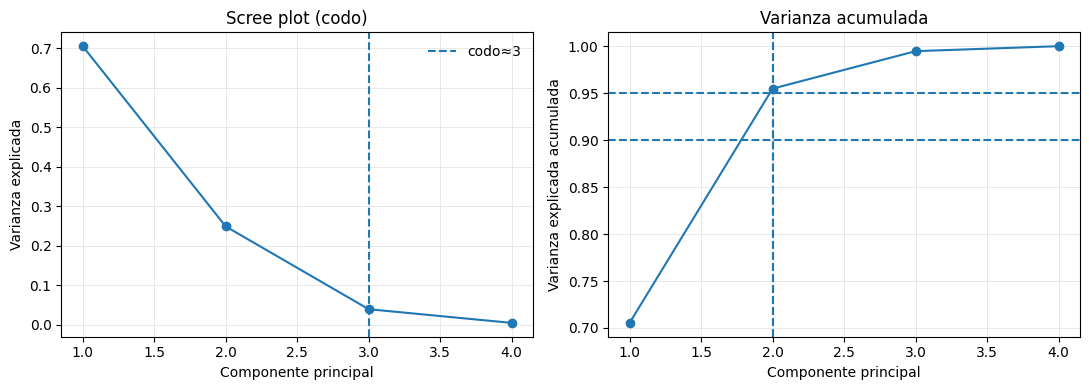

In [12]:
# --------- Gráficos ----------
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
 
# (a) Scree / codo
axs[0].plot(ks, expl, marker="o")
axs[0].set_xlabel("Componente principal")
axs[0].set_ylabel("Varianza explicada")
axs[0].set_title("Scree plot (codo)")
axs[0].grid(True, linewidth=0.4, alpha=0.5)
axs[0].axvline(k_elbow, linestyle="--", label=f"codo≈{k_elbow}")
axs[0].legend(frameon=False)
 
# (b) Acumulada con líneas de referencia
axs[1].plot(ks, cum, marker="o")
axs[1].set_xlabel("Componente principal")
axs[1].set_ylabel("Varianza explicada acumulada")
axs[1].set_title("Varianza acumulada")
axs[1].grid(True, linewidth=0.4, alpha=0.5)
axs[1].axhline(0.90, linestyle="--"); axs[1].axvline(k90, linestyle="--")
axs[1].axhline(0.95, linestyle="--"); axs[1].axvline(k95, linestyle="--")
 
plt.tight_layout(); plt.show()

In [13]:
# Elige el número de componentes (puedes usar 0.95 para varianza acumulada)
 
k = k_elbow
 
pca_pipe = Pipeline(steps=[
    ("pre", preprocessor_num),         # tu preprocesador tal cual
    ("std_for_pca", StandardScaler()), # re-estandarización para usar correlaciones
    ("pca", PCA(n_components=k, svd_solver="full", random_state=0)),
 
])
 
# --- FIT en train ---
pca_pipe.fit(X_train_num)
 
# --- TRANSFORM en train y test ---
T_train = pca_pipe.transform(X_train_num)
T_test  = pca_pipe.transform(X_test_num)
 
# DataFrames de scores
pc_cols = [f"PC{i+1}" for i in range(T_train.shape[1])]
T_train_df = pd.DataFrame(T_train, columns=pc_cols, index=X_train_num.index)
T_test_df  = pd.DataFrame(T_test,  columns=pc_cols, index=X_test_num.index)
 
# Varianza explicada
pca_step = pca_pipe.named_steps["pca"]
expl = pca_step.explained_variance_ratio_
print("Varianza explicada:", np.round(expl, 6))
print("Acumulada:", np.round(np.cumsum(expl), 6))
 
# Guardar outputs (opcional)
T_train_df.to_csv("T_train_PCA.csv", index=False)
T_test_df.to_csv("T_test_PCA.csv", index=False)
 
print("Shapes -> T_train:", T_train_df.shape, "| T_test:", T_test_df.shape)
display(T_train_df.head())

Varianza explicada: [0.70541  0.249367 0.039905]
Acumulada: [0.70541  0.954778 0.994683]
Shapes -> T_train: (105, 3) | T_test: (35, 3)


,PC1,PC2,PC3
83,-2.523605,0.712473,-0.035491
60,-0.006879,-1.388858,-0.037006
106,-0.766929,-1.550187,-0.149017
89,1.608240,-0.315419,-0.230880
78,1.186884,0.264001,0.297220


In [14]:
# Solo si k >= 2
import plotly.express as px
 
df_plot2 = T_train_df.iloc[:, :2].copy()
df_plot2["objetivo"] = y_train.loc[T_train_df.index].astype(str)
fig2 = px.scatter(df_plot2, x="PC1", y="PC2", color="objetivo",
                  opacity=0.85, title="PC1 vs PC2 por 'objetivo' (train)", height=550)
fig2.update_traces(marker=dict(size=6))
fig2.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig2.show()

In [15]:
#### Solo si k>=3
df_plot = T_train_df.iloc[:, :3].copy()          # PC1, PC2, PC3
# Alinea objetivo con los índices de T_train_df
df_plot["objetivo"] = y_train.loc[T_train_df.index].astype(str)
 
fig = px.scatter_3d(
    df_plot,
    x="PC1", y="PC2", z="PC3",
    color="objetivo",
    opacity=0.85,
    title="PC1–PC2–PC3 por ‘objetivo’ (train)",
    height=600
)
fig.update_traces(marker=dict(size=5))
fig.update_layout(scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3"))
fig.show()

In [16]:
# === Concatenar PCs (numéricas) con categóricas codificadas ===
# Asegura alineación por índice
df_train_cat_encode = df_train_cat_encode.reindex(T_train_df.index)
df_test_cat_encode  = df_test_cat_encode.reindex(T_test_df.index)
 
T_train_final = pd.concat([T_train_df, df_train_cat_encode], axis=1)
T_test_final  = pd.concat([T_test_df,  df_test_cat_encode], axis=1)
 
# Añadir columna objetivo (alineada por índice)
T_train_final_out = T_train_final.copy()
T_test_final_out  = T_test_final.copy()
 
T_train_final_out["objetivo"] = y_train.loc[T_train_final.index].astype(str)
T_test_final_out["objetivo"]  = y_test.loc[T_test_final.index].astype(str)
 
 
print("T_train_final:", T_train_final.shape)
print("T_test_final :", T_test_final.shape)
 
T_train_final.to_csv("T_train_final.csv", index=False)
T_test_final.to_csv("T_test_final.csv", index=False)
T_train_final_out.to_csv("T_train_final_objetivo.csv", index=False)
T_test_final_out.to_csv("T_test_final_objetivo.csv", index=False)
# X_train_final.head()

T_train_final: (105, 7)
T_test_final : (35, 7)


In [17]:
T_train_final_out

,PC1,PC2,PC3,color___amarillo,color___azul,color___rojo,nivel,objetivo
83,-2.523605,0.712473,-0.035491,1.0,0.0,0.0,0.0,Iris-setosa
60,-0.006879,-1.388858,-0.037006,1.0,0.0,0.0,1.0,Iris-versicolor
106,-0.766929,-1.550187,-0.149017,0.0,1.0,0.0,1.0,Iris-versicolor
89,1.608240,-0.315419,-0.230880,0.0,0.0,1.0,0.0,Iris-virginica
78,1.186884,0.264001,0.297220,0.0,0.0,1.0,0.0,Iris-versicolor
...,...,...,...,...,...,...,...,...
9,2.226429,1.871127,-0.395954,0.0,0.0,1.0,1.0,Iris-virginica
103,0.582052,0.402005,-0.597258,0.0,0.0,1.0,0.0,Iris-versicolor
67,0.016731,-0.272584,-0.632513,1.0,0.0,0.0,1.0,Iris-versicolor
117,2.426533,2.524599,0.144135,0.0,0.0,1.0,1.0,Iris-virginica


In [18]:
# === Guardar artefactos ===
import joblib
import json
 
# 1) Pipelines ya FIT: preprocessor_cat y pca_pipe
joblib.dump(preprocessor_cat, "preprocessor_cat.joblib")
joblib.dump(pca_pipe, "pca_pipe_num.joblib")   # (preprocessor_num + StdScaler + PCA)
 
# 2) Metadatos útiles para producción
meta = {
    "cols_num": cols_num,            # columnas numéricas originales
    "cols_cat": cols_cat,            # columnas categóricas originales
    "pc_cols": list(T_train_df.columns),            # nombres de PCs (PC1, PC2, …)
    "cat_out_cols": list(df_train_cat_encode.columns)  # columnas codificadas finales (OHE + Ordinal)
}
with open("pca_metadata.json", "w") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

In [19]:
# === Crear archivo ZIP con entregables ===
import zipfile
import os
from datetime import datetime

# Nombre del archivo ZIP (puedes cambiarlo si lo deseas)
nombre_zip = "entregables_PCA.zip"

# Lista de archivos a incluir en el ZIP según los entregables solicitados
archivos_entregables = [
    # 1) boxplots_numericas.png (si existe)
    # 2) histogramas_numericas.png (si existe)
    "pca_metadata.json",              # 3) pca_metadata.json
    "pca_pipe_num.joblib",            # 4) pca_pipe_num.joblib
    "preprocessor_cat.joblib",        # 5) preprocessor_cat.joblib
    "T_test_final.csv",               # 6) T_test_final.csv
    "T_test_final_objetivo.csv",      # 7) T_test_final_objetivo.csv
    "T_test_PCA.csv",                 # 8) T_test_PCA.csv
    "T_train_final.csv",              # 9) T_train_final.csv
    "T_train_final_objetivo.csv",     # 10) T_train_final_objetivo.csv
    "T_train_PCA.csv",                # 11) T_train_PCA.csv
]

# Crear el archivo ZIP
with zipfile.ZipFile(nombre_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    archivos_agregados = []
    archivos_faltantes = []
    
    for archivo in archivos_entregables:
        if os.path.exists(archivo):
            zipf.write(archivo, arcname=archivo)
            archivos_agregados.append(archivo)
            print(f"✓ Agregado: {archivo}")
        else:
            archivos_faltantes.append(archivo)
            print(f"✗ No encontrado: {archivo}")
    
    # Agregar este notebook como entregable 11
    notebook_path = "Preprocesamiento_PCA.ipynb"
    if os.path.exists(notebook_path):
        zipf.write(notebook_path, arcname=notebook_path)
        archivos_agregados.append(notebook_path)
        print(f"✓ Agregado: {notebook_path}")

print(f"\n{'='*60}")
print(f"Archivo ZIP creado: {nombre_zip}")
print(f"Total de archivos incluidos: {len(archivos_agregados)}")
if archivos_faltantes:
    print(f"\nArchivos no encontrados (no incluidos): {len(archivos_faltantes)}")
    for archivo in archivos_faltantes:
        print(f"  - {archivo}")
print(f"{'='*60}")

✓ Agregado: pca_metadata.json
✓ Agregado: pca_pipe_num.joblib
✓ Agregado: preprocessor_cat.joblib
✓ Agregado: T_test_final.csv
✓ Agregado: T_test_final_objetivo.csv
✓ Agregado: T_test_PCA.csv
✓ Agregado: T_train_final.csv
✓ Agregado: T_train_final_objetivo.csv
✓ Agregado: T_train_PCA.csv
✓ Agregado: Preprocesamiento_PCA.ipynb

Archivo ZIP creado: entregables_PCA.zip
Total de archivos incluidos: 10
✓ Agregado: T_train_final_objetivo.csv
✓ Agregado: T_train_PCA.csv
✓ Agregado: Preprocesamiento_PCA.ipynb

Archivo ZIP creado: entregables_PCA.zip
Total de archivos incluidos: 10
